In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Read dataset
car_price_df = pd.read_csv('CarPrice_Assignment.csv')

In [3]:
car_price_df.head(5)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
car_price_df.shape

(205, 26)

In [5]:
car_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

#### No column has missing values

In [6]:
car_price_df.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [7]:
# Drop car_ID as it is not reqiured
car_price_df.drop('car_ID', axis=1, inplace=True)

In [8]:
# Get all numerical columns
num_columns = list(filter(lambda x : x not in ['symboling'] and car_price_df[x].dtype in ['float64', 'int64'], car_price_df.columns))

In [9]:
len(num_columns)

14

### Checking outliers

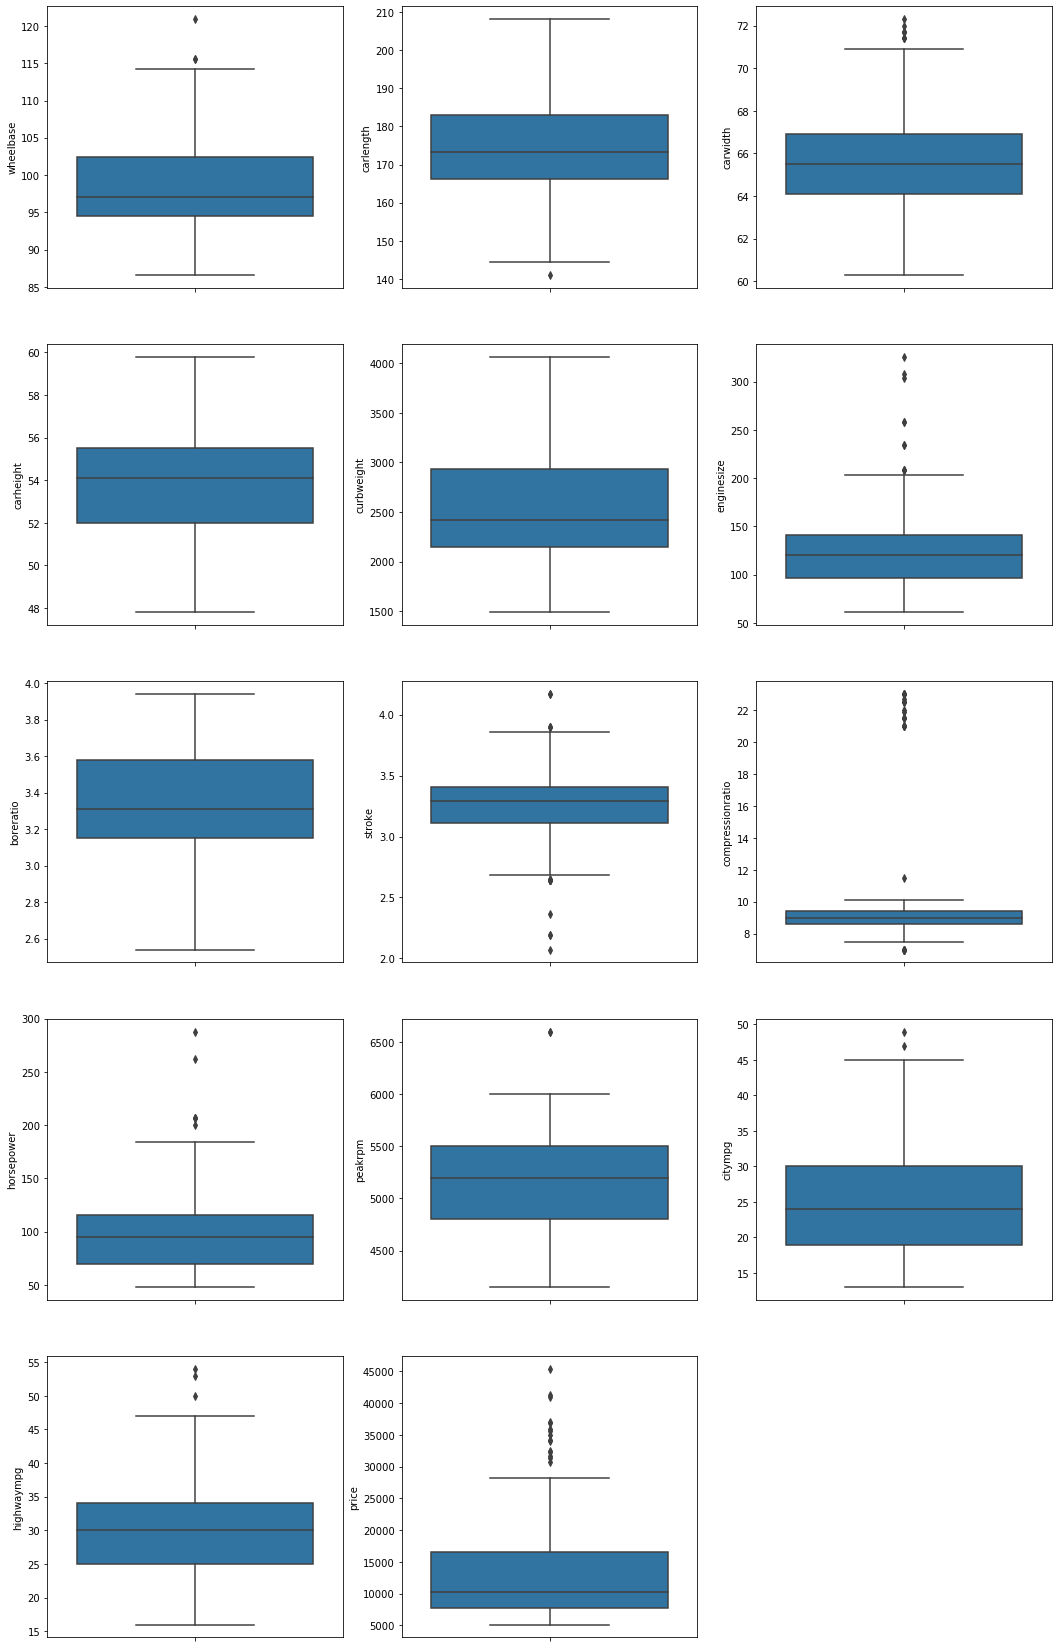

In [10]:
plt.figure(figsize=(18,30))
for i,col in enumerate(num_columns):
    plt.subplot(5,3,i+1)
    sns.boxplot(y = car_price_df[col])
    
plt.show()

#### Drive Car Company and Model from CarName

In [11]:
carname = car_price_df['CarName'].str.split(' ', n = 1, expand = True)
company = carname[0]

# Drop CarName
car_price_df.drop('CarName', axis = 1, inplace = True)
car_price_df

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,-1,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,-1,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,-1,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


### Analyzing Car Company

In [12]:
company.value_counts().sort_index()

Nissan          1
alfa-romero     3
audi            7
bmw             8
buick           8
chevrolet       3
dodge           9
honda          13
isuzu           4
jaguar          3
maxda           2
mazda          15
mercury         1
mitsubishi     13
nissan         17
peugeot        11
plymouth        7
porcshce        1
porsche         4
renault         2
saab            6
subaru         12
toyota         31
toyouta         1
vokswagen       1
volkswagen      9
volvo          11
vw              2
Name: 0, dtype: int64

Here you can see there are some issue in data.There are few companies present with the different spellings the data.
So Let's fix those

<table>
    <tr>
        <td>List of companies</td>
        <td>Final Name</td>
    </tr>
    <tr>
        <td>maxda, mazda</td>
        <td>mazda</td>
    <tr>
        <td>Nissan, nissan</td>
        <td>nissan</td>
    </tr>
    <tr>
        <td>porcshce, porsche</td>
        <td>porsche</td>
    </tr>
    <tr>
        <td>toyota, toyouta</td>
        <td>toyota</td>
    </tr>
    <tr>
        <td>vokswagen, volkswagen, vw</td>
        <td>volkswagen</td>
    </tr>
</table>  

In [13]:
company.replace(to_replace={'maxda': 'mazda', 'Nissan': 'nissan', 'porcshce': 'porsche', 
                            'toyouta': 'toyota', 'vokswagen': 'volkswagen', 'vw': 'volkswagen'}, inplace = True)
company.value_counts().sort_index()

alfa-romero     3
audi            7
bmw             8
buick           8
chevrolet       3
dodge           9
honda          13
isuzu           4
jaguar          3
mazda          17
mercury         1
mitsubishi     13
nissan         18
peugeot        11
plymouth        7
porsche         5
renault         2
saab            6
subaru         12
toyota         32
volkswagen     12
volvo          11
Name: 0, dtype: int64

In [14]:
car_price_df['Company'] = company
car_price_df

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,Company
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,...,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0,volvo
201,-1,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,...,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0,volvo
202,-1,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,...,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0,volvo
203,-1,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,...,idi,3.01,3.40,23.0,106,4800,26,27,22470.0,volvo


### Dummy Variables


In [15]:
cat_columns = ['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype',
              'cylindernumber', 'fuelsystem', 'Company']

In [16]:
for col in cat_columns:
    category = pd.get_dummies(car_price_df[col], drop_first = True)
    category.rename(mapper = lambda x: f'{col}_{x}', axis = 1, inplace = True)
    car_price_df = pd.concat([car_price_df, category], axis = 1)
    car_price_df.drop(col, axis = 1, inplace = True)
    
car_price_df.head(5)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,Company_nissan,Company_peugeot,Company_plymouth,Company_porsche,Company_renault,Company_saab,Company_subaru,Company_toyota,Company_volkswagen,Company_volvo
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,...,0,0,0,0,0,0,0,0,0,0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,...,0,0,0,0,0,0,0,0,0,0
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,...,0,0,0,0,0,0,0,0,0,0
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,...,0,0,0,0,0,0,0,0,0,0
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,...,0,0,0,0,0,0,0,0,0,0


## Splitting the data into Training and Test data set

In [17]:
# import required library
from sklearn.model_selection import train_test_split

In [18]:
df_train, df_test = train_test_split(car_price_df, train_size = 0.7, test_size = 0.3, random_state = 100)

## Rescalling the features

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [20]:
df_train.loc[:,num_columns] = scaler.fit_transform(df_train.loc[:,num_columns])
df_train

c:\users\ragnar\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,Company_nissan,Company_peugeot,Company_plymouth,Company_porsche,Company_renault,Company_saab,Company_subaru,Company_toyota,Company_volkswagen,Company_volvo
122,0.244828,0.426016,0.291667,0.265487,0.272692,0.139623,0.230159,0.525253,0.15000,0.083333,...,0,0,1,0,0,0,0,0,0,0
125,0.272414,0.452033,0.666667,0.212389,0.500388,0.339623,1.000000,0.464646,0.15625,0.395833,...,0,0,0,1,0,0,0,0,0,0
166,0.272414,0.448780,0.308333,0.424779,0.314973,0.139623,0.444444,0.449495,0.15000,0.266667,...,0,0,0,0,0,0,0,1,0,0
1,0.068966,0.450407,0.316667,0.088496,0.411171,0.260377,0.626984,0.247475,0.12500,0.262500,...,0,0,0,0,0,0,0,0,0,0
199,0.610345,0.775610,0.575000,0.858407,0.647401,0.260377,0.746032,0.484848,0.03125,0.475000,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.334483,0.508943,0.425000,0.336283,0.354926,0.184906,0.388889,0.641414,0.03125,0.283333,...,0,0,0,0,0,0,0,0,0,0
103,0.475862,0.707317,0.516667,0.646018,0.609775,0.452830,0.595238,0.545455,0.12500,0.433333,...,1,0,0,0,0,0,0,0,0,0
67,0.806897,0.809756,0.833333,0.769912,0.786268,0.460377,0.714286,0.732323,0.90625,0.312500,...,0,0,0,0,0,0,0,0,0,0
24,0.244828,0.263415,0.291667,0.247788,0.185803,0.109434,0.230159,0.525253,0.15000,0.083333,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
corr = df_train.corr()
plt.figure(figsize=(20,60))
sns.heatmap(corr, annot = True)
plt.show()

## Dividing into X and y set for model building

In [21]:
y_train = df_train.pop('price')
X_train = df_train

## Building Model

### RFE

In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [23]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# Let's start with 12 features
rfe = RFE(lm, 12)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('wheelbase', False, 11),
 ('carlength', False, 17),
 ('carwidth', True, 1),
 ('carheight', False, 13),
 ('curbweight', True, 1),
 ('enginesize', True, 1),
 ('boreratio', True, 1),
 ('stroke', True, 1),
 ('compressionratio', False, 22),
 ('horsepower', False, 6),
 ('peakrpm', False, 8),
 ('citympg', False, 32),
 ('highwaympg', False, 23),
 ('symboling_-1', False, 34),
 ('symboling_0', False, 44),
 ('symboling_1', False, 46),
 ('symboling_2', False, 45),
 ('symboling_3', False, 47),
 ('fueltype_gas', False, 26),
 ('aspiration_turbo', False, 10),
 ('doornumber_two', False, 49),
 ('carbody_hardtop', False, 28),
 ('carbody_hatchback', False, 27),
 ('carbody_sedan', False, 29),
 ('carbody_wagon', False, 30),
 ('drivewheel_fwd', False, 54),
 ('drivewheel_rwd', False, 36),
 ('enginelocation_rear', True, 1),
 ('enginetype_dohcv', False, 9),
 ('enginetype_l', False, 5),
 ('enginetype_ohc', False, 51),
 ('enginetype_ohcf', False, 19),
 ('enginetype_ohcv', False, 43),
 ('enginetype_rotor', True,

In [24]:
# Columns selected through RFE

col = X_train.columns[rfe.support_]
col

Index(['carwidth', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       'enginelocation_rear', 'enginetype_rotor', 'cylindernumber_three',
       'cylindernumber_twelve', 'cylindernumber_two', 'Company_bmw',
       'Company_porsche'],
      dtype='object')

## Building model using statsmodel

In [27]:
import statsmodels.api as sm

In [29]:
X_train_rfe = X_train[col]
X_train_rfe = sm.add_constant(X_train_rfe)

In [30]:
lm = sm.OLS(y_train, X_train_rfe).fit()

In [31]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     130.2
Date:                Sat, 07 Mar 2020   Prob (F-statistic):           6.86e-65
Time:                        16:32:22   Log-Likelihood:                 194.22
No. Observations:                 143   AIC:                            -364.4
Df Residuals:                     131   BIC:                            -328.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.10